<a href="https://colab.research.google.com/github/bh2045123-code/Assignment1-GridWorld-Qlearning/blob/main/Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf Assignment1-GridWorld-Qlearning
!git clone https://github.com/bh2045123-code/Assignment1-GridWorld-Qlearning.git
%cd Assignment1-GridWorld-Qlearning
!git log -1 --oneline
!sed -n '1,220p' gridworld/env.py | nl | sed -n '130,220p'

Cloning into 'Assignment1-GridWorld-Qlearning'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 62.95 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Assignment1-GridWorld-Qlearning/Assignment1-GridWorld-Qlearning
3e1aa4b (HEAD -> main, origin/main, origin/HEAD) feat(demo): add pygame visualizer
   106	        x, y = pos
   107	        dist = abs(tx - x) + abs(ty - y)
   108	        return -0.05 * dist
       
   109	    # --- Debug text render ---
       
   110	    def render_text(self) -> str:
   111	        grid = [["." for _ in range(self.W)] for _ in range(self.H)]
   112	        for (wx, wy) in self.walls:
   113	            grid[wy][wx] = "#"
   114	        for (tx, ty) in self.traps:
   115	            grid[ty][tx] = "X"
   116	        gx, gy = self.goal
   117	   

In [3]:
!pip -q install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.4 MB/s eta 0:00:00


In [4]:
import sys, os, importlib, types
print("CWD:", os.getcwd())
print("In sys.path[0:3]:", sys.path[0:3])
# 确保当前目录在 sys.path 第一个
if os.getcwd() != sys.path[0]:
    sys.path.insert(0, os.getcwd())
print("Fixed sys.path[0]:", sys.path[0])


CWD: /content/Assignment1-GridWorld-Qlearning/Assignment1-GridWorld-Qlearning
In sys.path[0:3]: ['/content', '/env/python', '/usr/lib/python312.zip']
Fixed sys.path[0]: /content/Assignment1-GridWorld-Qlearning/Assignment1-GridWorld-Qlearning


In [5]:
import importlib, gridworld.env as ge
importlib.reload(ge)
from gridworld.env import GridWorldEnv
import inspect
print("Render_text source:")
print(inspect.getsource(GridWorldEnv.render_text))

Render_text source:
    def render_text(self) -> str:
        grid = [["." for _ in range(self.W)] for _ in range(self.H)]
        for (wx, wy) in self.walls:
            grid[wy][wx] = "#"
        for (tx, ty) in self.traps:
            grid[ty][tx] = "X"
        gx, gy = self.goal
        grid[gy][gx] = "G"
        tx, ty = self.treasure
        if not self.has_treasure:
            grid[ty][tx] = "T"
        sx, sy = self.start
        if grid[sy][sx] == ".":
            grid[sy][sx] = "S"
        x, y = self.pos
        grid[y][x] = "*" if self.has_treasure else "P"

        lines = []
        for row in range(self.H):
            lines.append(" ".join(grid[row]))
        legend = "Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start"
        return "\n".join(lines + [legend])



In [6]:
from gridworld.env import GridWorldEnv
from gridworld.agent import QAgent
from gridworld.trainer import Trainer

env = GridWorldEnv(shaping=True, max_steps=200)
n_states = 2 * env.W * env.H
agent = QAgent(
    n_states=n_states, n_actions=5,
    alpha=0.2, gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995,
    seed=42
)
trainer = Trainer(env, agent, episodes=1000, render_every=0)
trainer.run()
trainer.summary()

{'episodes': 1000,
 'avg_return': 21.87185,
 'avg_length': 14.374,
 'success_rate': 0.996,
 'epsilon_final': 0.05}

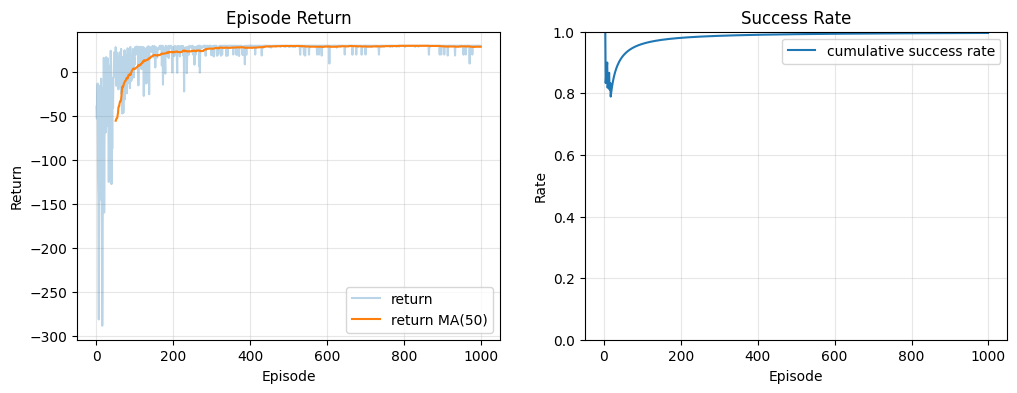

In [7]:
import matplotlib.pyplot as plt
import numpy as np

ret = trainer.ep_returns
succ = trainer.ep_success

def moving_avg(x, k=50):
    if len(x) < k:
        return np.array(x, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0))
    return (c[k:] - c[:-k]) / float(k)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ret, alpha=0.3, label='return')
ma = moving_avg(ret, 50)
plt.plot(np.arange(len(ma))+50, ma, label='return MA(50)')
plt.title('Episode Return'); plt.xlabel('Episode'); plt.ylabel('Return')
plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1,2,2)
cum_succ = np.cumsum(succ)/np.arange(1, len(succ)+1)
plt.plot(cum_succ, label='cumulative success rate')
plt.title('Success Rate'); plt.xlabel('Episode'); plt.ylabel('Rate'); plt.ylim(0,1)
plt.grid(True, alpha=0.3); plt.legend()

plt.show()

In [8]:
s = env.reset()
done = False
steps = 0
total_r = 0.0
print(env.render_text(), '\n')

while not done and steps < 100:
    qrow = agent.Q[s]
    a = max(range(len(qrow)), key=lambda i: qrow[i])  # greedy
    s, r, done, info = env.step(a)
    total_r += r
    steps += 1
    print(f"Step {steps}, a={a}, r={r:.2f}, done={done}, info={info}")
    print(env.render_text(), '\n')

print(f"Greedy result: steps={steps}, return={total_r:.2f}, success={'success' in info}")

. . . . G
. # X X .
. # T . .
. . . # .
P . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start 

Step 1, a=0, r=-0.05, done=False, info={}
. . . . G
. # X X .
. # T . .
P . . # .
S . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start 

Step 2, a=1, r=-0.05, done=False, info={}
. . . . G
. # X X .
. # T . .
. P . # .
S . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start 

Step 3, a=1, r=-0.05, done=False, info={}
. . . . G
. # X X .
. # T . .
. . P # .
S . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start 

Step 4, a=0, r=9.75, done=False, info={'picked': True}
. . . . G
. # X X .
. # * . .
. . . # .
S . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wall, X=trap, S=start 

Step 5, a=1, r=-0.05, done=False, info={}
. . . . G
. # X X .
. # . * .
. . . # .
S . . . .
Legend: P=player, *=player+treasure, T=treasure, G=goal, #=wal

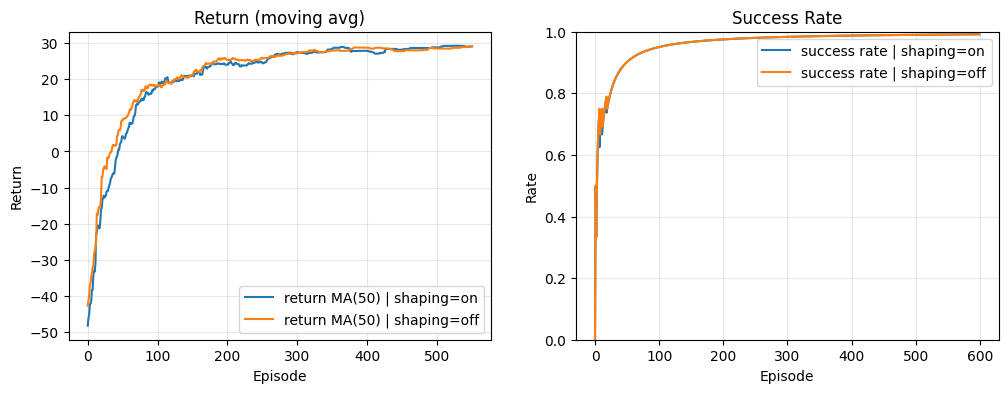

In [9]:
import matplotlib.pyplot as plt, numpy as np
from gridworld.env import GridWorldEnv
from gridworld.agent import QAgent
from gridworld.trainer import Trainer

def run_once(shaping: bool, seed: int, episodes: int=600):
    env = GridWorldEnv(shaping=shaping, max_steps=200)
    n_states = 2 * env.W * env.H
    agent = QAgent(n_states=n_states, n_actions=5,
                   alpha=0.2, gamma=0.99,
                   eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                   seed=seed)
    tr = Trainer(env, agent, episodes=episodes, render_every=0)
    tr.run()
    return tr

def moving_avg(x, k=50):
    if len(x) < k: return np.array(x, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0))
    return (c[k:] - c[:-k]) / float(k)

tr_on  = run_once(shaping=True,  seed=1, episodes=600)
tr_off = run_once(shaping=False, seed=1, episodes=600)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(moving_avg(tr_on.ep_returns,50), label='return MA(50) | shaping=on')
plt.plot(moving_avg(tr_off.ep_returns,50), label='return MA(50) | shaping=off')
plt.title('Return (moving avg)'); plt.xlabel('Episode'); plt.ylabel('Return'); plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1,2,2)
cum_on  = np.cumsum(tr_on.ep_success)/np.arange(1,len(tr_on.ep_success)+1)
cum_off = np.cumsum(tr_off.ep_success)/np.arange(1,len(tr_off.ep_success)+1)
plt.plot(cum_on,  label='success rate | shaping=on')
plt.plot(cum_off, label='success rate | shaping=off')
plt.title('Success Rate'); plt.xlabel('Episode'); plt.ylabel('Rate'); plt.ylim(0,1); plt.grid(True, alpha=0.3); plt.legend()
plt.show()